## 変数の種類

* <strong>stochastic(確率的)</strong> variables are variables that are not deterministic, i.e., even if you knew all the values of the variables' parameters and components, it would still be random. Included in this category are instances of classes Poisson, DiscreteUniform, and Exponential.

* <strong>deterministic(決定的)</strong> variables are variables that are not random if the variables' parameters and components were known. This might be confusing at first: a quick mental check is if I knew all of variable foo's component variables, I could determine what foo's value is.

## Example: Bayesian A/B testing

### サイトA

In [1]:
import pymc3 as pm

# The parameters are the bounds of the Uniform.
with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1)

$p_a$ : N人がサイトAを見せられた時にユーザーが最終的にコンバージョンにつながる確率

In [2]:
import scipy.stats as stats
import numpy as np
#set constants
p_true = 0.05  # remember, this is unknown.
N = 1500

# sample N Bernoulli random variables from Ber(0.05).
# each random variable has a 0.05 chance of being a 1.
# this is the data-generation step
occurrences = stats.bernoulli.rvs(p_true, size=N)

print(occurrences) # Remember: Python treats True == 1, and False == 0
print(np.sum(occurrences))

[0 0 0 ... 0 0 0]
63


In [3]:
# Occurrences.mean is equal to n/N.
print("What is the observed frequency in Group A? %.4f" % np.mean(occurrences))
print("Does this equal the true frequency? %s" % (np.mean(occurrences) == p_true))

What is the observed frequency in Group A? 0.0420
Does this equal the true frequency? False


In [4]:
#include the observations, which are Bernoulli
with model:
    obs = pm.Bernoulli("obs", p, observed=occurrences)
    # To be explained in chapter 3
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
    burned_trace = trace[1000:]

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [p]
Sampling 2 chains: 100%|██████████| 37000/37000 [00:04<00:00, 9133.93draws/s] 
The number of effective samples is smaller than 25% for some parameters.


未知数$p_a$の事後分布

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


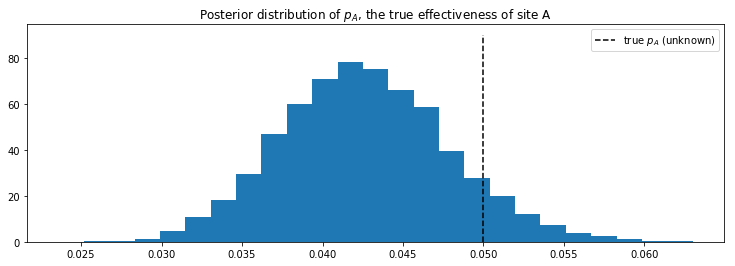

In [5]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

figsize(12.5, 4)
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.hist(burned_trace["p"], bins=25, histtype="stepfilled", normed=True)
plt.legend();

### A and B Together

In [6]:
import pymc3 as pm
figsize(12, 4)

#these two quantities are unknown to us.
true_p_A = 0.05
true_p_B = 0.04

#notice the unequal sample sizes -- no problem in Bayesian analysis.
N_A = 1500
N_B = 750

#generate some observations
observations_A = stats.bernoulli.rvs(true_p_A, size=N_A)
observations_B = stats.bernoulli.rvs(true_p_B, size=N_B)
print("Obs from Site A: ", observations_A[:30], "...")
print("Obs from Site B: ", observations_B[:30], "...")

Obs from Site A:  [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0] ...
Obs from Site B:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0] ...


In [7]:
print(np.mean(observations_A))
print(np.mean(observations_B))

0.048
0.04


In [8]:
# Set up the pymc3 model. Again assume Uniform priors for p_A and p_B.
with pm.Model() as model:
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_A - p_B)

    
    # Set of observations, in this case we have two observation datasets.
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)

    # To be explained in chapter 3.
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)
    burned_trace=trace[1000:]

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 2 chains: 100%|██████████| 41000/41000 [00:06<00:00, 5944.78draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [9]:
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


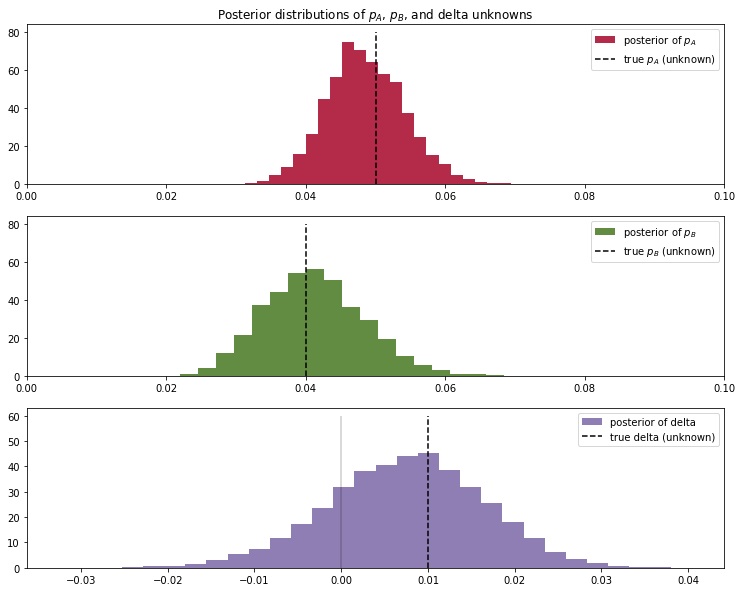

In [10]:

figsize(12.5, 10)

#histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", normed=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", normed=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", normed=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

In [11]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(delta_samples < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(delta_samples > 0))

Probability site A is WORSE than site B: 0.202
Probability site A is BETTER than site B: 0.798


## An algorithm for human deceit(カンニングをした生徒の割合）

今回は二項分布を当てはめる

In [12]:
N = 100
with pm.Model() as model:
    #カンニングの割合
    p = pm.Uniform("freq_cheating", 0, 1)

In [13]:
with model:
    true_answers = pm.Bernoulli("truths", p, shape=N, testval=np.random.binomial(1, 0.5, N))

In [14]:
with model:
    first_coin_flips = pm.Bernoulli("first_flips", 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))
print(first_coin_flips.tag.test_value)

[1 1 0 0 1 1 1 1 0 0 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 1 1 1 1 0 1 0 0 1 0
 1 0 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1
 0 1 0 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 1]


In [15]:
with model:
    second_coin_flips = pm.Bernoulli("second_flips", 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))

In [16]:
import theano.tensor as tt
with model:
    val = first_coin_flips*true_answers + (1 - first_coin_flips)*second_coin_flips
    observed_proportion = pm.Deterministic("observed_proportion", tt.sum(val)/float(N))

In [17]:
observed_proportion.tag.test_value

array(0.52999997)

次に観測データを見ていく

In [18]:
#コイン投げをした面接の結果「はい」という回答が３５だったとする
X = 35

with model:
    observations = pm.Binomial("obs", N, observed_proportion, observed=X)

In [19]:
# To be explained in Chapter 3!
with model:
    step = pm.Metropolis(vars=[p])
    trace = pm.sample(40000, step=step)
    burned_trace = trace[15000:]

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [freq_cheating]
>BinaryGibbsMetropolis: [truths, first_flips, second_flips]
Sampling 2 chains: 100%|██████████| 81000/81000 [11:03<00:00, 122.01draws/s]
The number of effective samples is smaller than 10% for some parameters.


/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


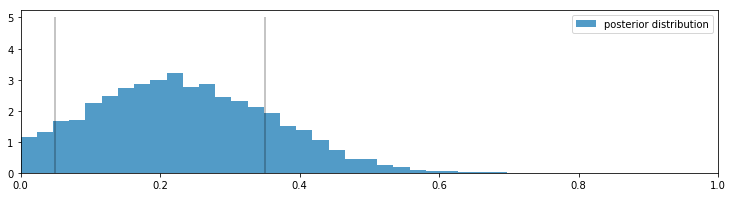

In [20]:
figsize(12.5, 3)
p_trace = burned_trace["freq_cheating"][15000:]
plt.hist(p_trace, histtype="stepfilled", normed=True, alpha=0.85, bins=30, 
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.3)
plt.xlim(0, 1)
plt.legend();

具体的な数値はわからないが、カンニングがないことはありえないことはわかる

 #### Alternative PyMC3 Model（こっちの方が計算時間早くて良き）

$$\begin{align}
P(\text{"Yes"}) = & P( \text{Heads on first coin} )P( \text{cheater} ) + P( \text{Tails on first coin} )P( \text{Heads on second coin} ) \\\\
& = \frac{1}{2}p + \frac{1}{2}\frac{1}{2}\\\\
& = \frac{p}{2} + \frac{1}{4}
\end{align}$$


p（「はい」と回答する確率）の値がわかれば同じように分布を求めることができる

In [21]:
with pm.Model() as model:
    #カンニングの割合
    p = pm.Uniform("freq_cheating", 0, 1)
    #はいの割合
    p_skewed = pm.Deterministic("p_skewed", 0.5*p + 0.25)

In [22]:
with model:
    yes_responses = pm.Binomial("number_cheaters", 100, p_skewed, observed=35)

In [23]:
with model:
    # To Be Explained in Chapter 3!
    step = pm.Metropolis()
    trace = pm.sample(25000, step=step)
    burned_trace = trace[2500:]

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [freq_cheating]
Sampling 2 chains: 100%|██████████| 51000/51000 [00:04<00:00, 10760.13draws/s]
The number of effective samples is smaller than 25% for some parameters.


/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


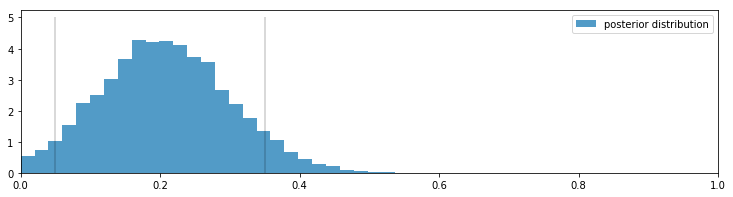

In [24]:
figsize(12.5, 3)
p_trace = burned_trace["freq_cheating"]
plt.hist(p_trace, histtype="stepfilled", normed=True, alpha=0.85, bins=30, 
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.2)
plt.xlim(0, 1)
plt.legend();

## Example: Challenger Space Shuttle Disaster 

Temp (F), O-Ring failure?
[[66.  0.]
 [70.  1.]
 [69.  0.]
 [68.  0.]
 [67.  0.]
 [72.  0.]
 [73.  0.]
 [70.  0.]
 [57.  1.]
 [63.  1.]
 [70.  1.]
 [78.  0.]
 [67.  0.]
 [53.  1.]
 [67.  0.]
 [75.  0.]
 [70.  0.]
 [81.  0.]
 [76.  0.]
 [79.  0.]
 [75.  1.]
 [76.  0.]
 [58.  1.]]


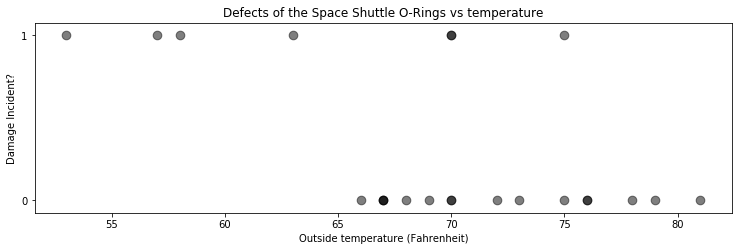

In [25]:
figsize(12.5, 3.5)
np.set_printoptions(precision=3, suppress=True)
challenger_data = np.genfromtxt("data/challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
#drop the NA values
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

#plot it, as a function of tempature (the first column)
print("Temp (F), O-Ring failure?")
print(challenger_data)

plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color="k",
            alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("Damage Incident?")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Defects of the Space Shuttle O-Rings vs temperature");

上のグラフは破損発生と外気温の関係の把握のためのプロット<br>
気温tの時の破損発生確率を求めたい

ロジスティック回帰を利用<br>
$$p(t) = \frac{1}{ 1 + e^{ \;\beta t + \alpha } } $$

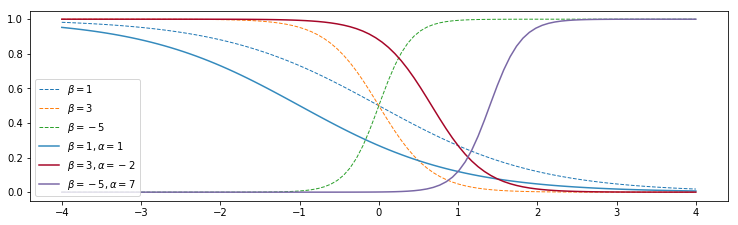

In [26]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

x = np.linspace(-4, 4, 100)

plt.plot(x, logistic(x, 1), label=r"$\beta = 1$", ls="--", lw=1)
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$", ls="--", lw=1)
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$", ls="--", lw=1)

plt.plot(x, logistic(x, 1, 1), label=r"$\beta = 1, \alpha = 1$",
         color="#348ABD")
plt.plot(x, logistic(x, 3, -2), label=r"$\beta = 3, \alpha = -2$",
         color="#A60628")
plt.plot(x, logistic(x, -5, 7), label=r"$\beta = -5, \alpha = 7$",
         color="#7A68A6")

plt.legend(loc="lower left");

In [27]:
import pymc3 as pm

temperature = challenger_data[:, 0]
D = challenger_data[:, 1]  # defect or not?

#notice the`value` here. We explain why below.
with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0)
    alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
    #pはロジスティック回帰
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*temperature + alpha)))

In [28]:
# connect the probabilities in `p` with our observations through a
# Bernoulli random variable.
with model:
    observed = pm.Bernoulli("bernoulli_obs", p, observed=D)
    
    # Mysterious code to be explained in Chapter 3
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(120000, step=step, start=start)
    burned_trace = trace[100000::2]

logp = -19.024, ||grad|| = 9.9071: 100%|██████████| 27/27 [00:00<00:00, 1688.68it/s]  
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
Sampling 2 chains: 100%|██████████| 241000/241000 [00:40<00:00, 5896.36draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


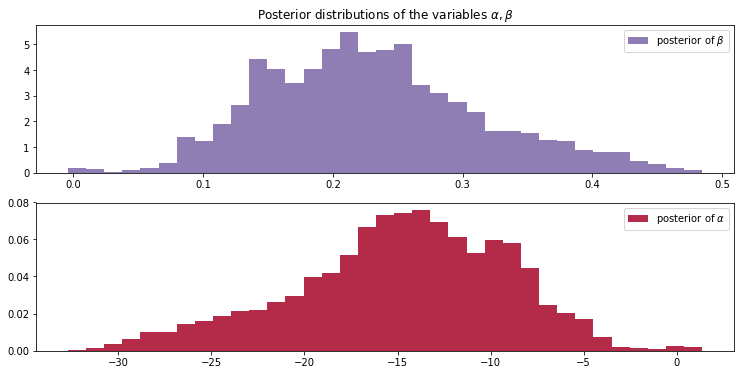

In [29]:
alpha_samples = burned_trace["alpha"][:, None]  # best to make them 1d
beta_samples = burned_trace["beta"][:, None]

figsize(12.5, 6)

#histogram of the samples:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#7A68A6", normed=True)
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628", normed=True)
plt.legend();

上記はモデルパラメータ$\alpha$と$\beta$についての事後分布

In [30]:
t = np.linspace(temperature.min() - 5, temperature.max()+5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)

mean_prob_t = p_t.mean(axis=0)

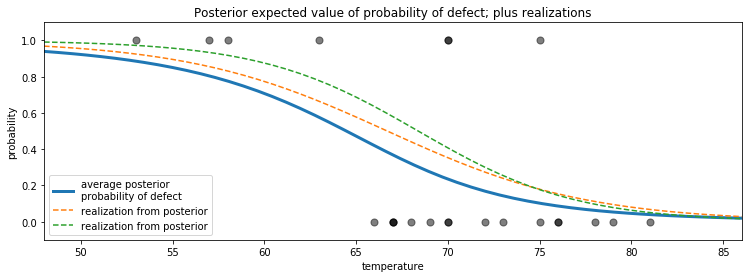

In [31]:
figsize(12.5, 4)

plt.plot(t, mean_prob_t, lw=3, label="average posterior \nprobability \
of defect")
plt.plot(t, p_t[0, :], ls="--", label="realization from posterior")
plt.plot(t, p_t[-2, :], ls="--", label="realization from posterior")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.title("Posterior expected value of probability of defect; \
plus realizations")
plt.legend(loc="lower left")
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("probability")
plt.xlabel("temperature");

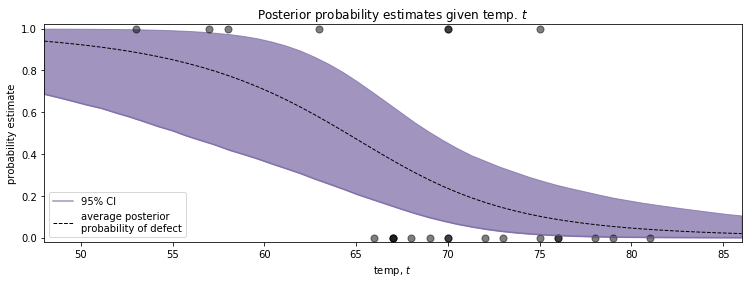

In [32]:
from scipy.stats.mstats import mquantiles

# vectorized bottom and top 2.5% quantiles for "confidence interval"
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.7,
                 color="#7A68A6")

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="average posterior \nprobability of defect")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="lower left")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.xlabel("temp, $t$")

plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given temp. $t$");

外気温３１度の場合

## Is our model appropriate?

事後分布から元のデータをサンプリングして本当のデータと似ているかを実証

In [33]:
N = 10000
with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0)
    alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*temperature + alpha)))
    observed = pm.Bernoulli("bernoulli_obs", p, observed=D)
    
    simulated = pm.Bernoulli("bernoulli_sim", p, shape=p.tag.test_value.shape)
    step = pm.Metropolis(vars=[p])
    trace = pm.sample(N, step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [beta]
>>Metropolis: [alpha]
>BinaryGibbsMetropolis: [bernoulli_sim]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:13<00:00, 1539.76draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


(20000, 23)


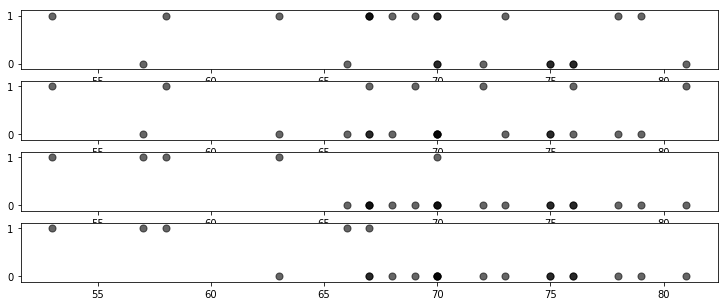

In [34]:
figsize(12.5, 5)

simulations = trace["bernoulli_sim"]
print(simulations.shape)

plt.title("Simulated dataset using posterior parameters")
figsize(12.5, 6)
for i in range(4):
    ax = plt.subplot(4, 1, i+1)
    plt.scatter(temperature, simulations[1000*i, :], color="k",
                s=50, alpha=0.6)

### セパレーションプロット

元のデータと新しいデータの比較に使う

In [35]:
posterior_probability = simulations.mean(axis=0)
print("posterior prob of defect(生成データ) | realized defect（破損発生） ")
for i in range(len(D)):
    print("%.2f                     |   %d" % (posterior_probability[i], D[i]))

posterior prob of defect(生成データ) | realized defect（破損発生） 
0.43                     |   0
0.23                     |   1
0.28                     |   0
0.32                     |   0
0.38                     |   0
0.16                     |   0
0.14                     |   0
0.23                     |   0
0.82                     |   1
0.61                     |   1
0.23                     |   1
0.06                     |   0
0.37                     |   0
0.89                     |   1
0.38                     |   0
0.09                     |   0
0.23                     |   0
0.04                     |   0
0.08                     |   0
0.05                     |   0
0.10                     |   1
0.08                     |   0
0.80                     |   1


In [36]:
ix = np.argsort(posterior_probability)
print("probb（破損発生の事後確率） | defect（破損発生）")
for i in range(len(D)):
    print("%.2f  |   %d" % (posterior_probability[ix[i]], D[ix[i]]))

probb（破損発生の事後確率） | defect（破損発生）
0.04  |   0
0.05  |   0
0.06  |   0
0.08  |   0
0.08  |   0
0.09  |   0
0.10  |   1
0.14  |   0
0.16  |   0
0.23  |   0
0.23  |   1
0.23  |   0
0.23  |   1
0.28  |   0
0.32  |   0
0.37  |   0
0.38  |   0
0.38  |   0
0.43  |   0
0.61  |   1
0.80  |   1
0.82  |   1
0.89  |   1


In [37]:
from urllib.request import urlretrieve

urlretrieve("https://git.io/vXtye","separation_plot.py")

('separation_plot.py', <http.client.HTTPMessage at 0x11701b4e0>)

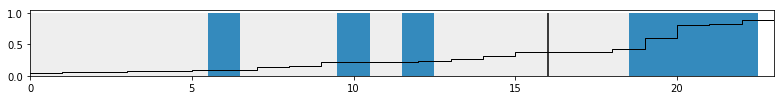

In [38]:
from separation_plot import separation_plot


figsize(11., 1.5)
separation_plot(posterior_probability, D)

## 演習問題

Text(0, 0.5, '$\\beta$')

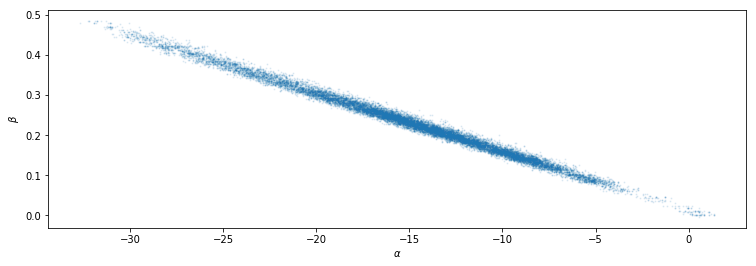

In [39]:
figsize(12.5,4)

plt.scatter(alpha_samples,beta_samples,alpha=0.1,s=1)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")